In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from IPython import display
plt.rcParams.update({'font.size': 8})

# 狗狼狐狸傻傻分不清楚(tensorflow)

支援python 版本: 3.5以上
支援tensorflow版本 : 2.2以上

這個實作是我在2016年在上海發起中國第一個國際人工智能競賽BOT(Brain of things) Shanghai 2016的初賽賽題，題目看似簡單是12種動物識別，但是所有選手拿到數據後，才發現真的一點都不簡單，除了這12種動物彼此之間很像之外，最大的困難點在於訓練組只有真實動物的圖片，但是測試集會出現這些動物的衍生作品(動漫、布偶、造型商品...)，對人類來說，我們很容易就能分辨出這個布偶是狗、還是是貓，但是對機器來說光是真貓真狗都需要數以萬計的圖片才能認識了那麼這些從原本真實的意義向外發散出來的衍生物，機器也能夠過他們學習過的特徵來做出正確的判斷嗎?

![Alt text](../images/animals.png)

這12種動物的代碼、名稱與定義如下

00 cat 猫                 (食肉目 猫科 猫屬 斑猫種 家猫亞種)
01 chipmunk 花栗鼠             (嚙齒目 松鼠科 花栗鼠屬)
02 dog 狗                 (食肉目 犬科 犬屬 灰狼種 家犬亞種)
03 fox 狐狸               (食肉目 犬科 北極狐屬/大耳狐屬/灰狐屬/狐屬)
04 giraffe 長頸鹿             (偶蹄目 長頸鹿科)
05 guinea pig 天竺鼠             (嚙齒目 豚鼠科 豚鼠屬)
06 hyena鬣狗               (食肉目 鬣狗科)
07 reindeer 馴鹿               (偶蹄目 鹿科 馴鹿屬)
08 sikadeer 梅花鹿             (偶蹄目 鹿科 鹿屬 梅花鹿種)
09 squirrel 松鼠               (嚙齒目 松鼠科)
10 weasel 黃鼬(黃鼠狼)        (食肉目 鼬科 鼬屬 黃鼬種)
11 wolf 狼                 (食肉目 犬科犬屬 灰狼種 )


In [2]:

import os
os.environ['TRIDENT_BACKEND'] = 'tensorflow'
#!pip install tridentx --upgrade
import trident as T
from trident import *
from trident.models import resnet

trident 0.7.1


Using TensorFlow backend.
Image Data Format: channels_last.
Image Channel Order: rgb.
1 Physical GPUs, 1 Logical GPUs


Opencv version:4.1.2.


Tensorflow version:2.4.0.
use device:/gpu:0.
executing_eagerly


Pillow version:7.1.2.


深度學習很重要的是解題的思路，要解決這樣的複雜問題，「不要從零開始」學習是非常重要的，因此，採用遷移學習是個不錯的方式，基於標準ImageNet數據訓練的預訓練模型來做為基礎精調，會比從零開始訓練的效果更好，更何這幾種動物本來就都有出現在ImageNet，現在主要的考驗就在於機器是否能將真動物身上學習到的抽樣特徵與這些非動物的造型物連結在一起。我們先測試看看，單純使用Imagenet預訓練模型對於這些圖片的分類能力如何。在trident中，可以直接呼叫ResNet50(include_top=True,pretrained=True,input_shape=(3, 224, 224), classes=1000,)的方式傳回帶有全連接層，類別為1000種，輸入形狀為(2,224,224)(如果是tensorflow版本則需要傳入(224,224,3))的imagenet預訓練ResNet50模型。(選擇ResNet50只是為了讓大部分的人的環境跑得動，如果你手上有足夠GPU，建議可以切換成ResNet101或ResNet152)。

In [3]:
#調用預訓練模型
#調用的模型會放置在 ~\.trident\models
resnet50=resnet.ResNet50(include_top=True,
             pretrained=True,
             input_shape=(224, 224,3),
             classes=1000)

model file is already existing, donnot need download again.


<p>傳回的ResNet50的型別是名為<em>ImageClassificationModel</em>的Model子類，ImageClassificationModel需要滿足<em>class_names(標籤清單)不為空</em>以及<em>preprocess_flow的清單內放置推論前需要的圖像處理函數</em>，這樣就可以直接調用infer_single_image(img,topk=1)來進行推論，當然，這邊的預訓練模型都已經幫大家設定好了，大家不需要做任何處理，但還是讓大家瞭解一下內部到底做了些甚麼，以ResNet50為例，他的preprocess_flow設定如下：</p>

<pre><code>
preprocess_flow=[resize((224,224),keep_aspect=True),#不扭曲比例縮放至224,224
    normalize(0,255), #像素除以255
    normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),#透過imagenet像素均值標準差再做一次正規化
    ]
</code></pre>

<p>至於infer_single_image(img,topk=1)這個函數中，img可以傳入的是一個<em>圖檔路徑</em>，或者是<em>PIL讀取的圖檔</em>，也可以是一個<em>圖檔向量(通道在後，RGB)</em></p>

先上萌貓一隻....

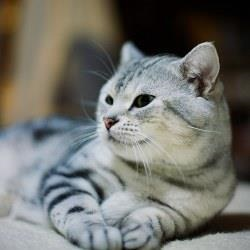

In [4]:
display.Image('../images/cat.jpg')

直接把推論結果(topk=5)列印出來，確認預訓練模型正確無誤

In [5]:
print(resnet50.infer_single_image('../images/cat.jpg',5))

{  n02124075	埃及猫: (285, 0.94789326),  n02123045	虎斑猫: (281, 0.028550506),  n02123159	山猫: (282, 0.019354474),  n02128757	雪豹: (289, 0.0022077516),  n02127052	猞猁: (287, 0.00033169737) }


接下來的挑戰就比較大了，是一隻...貓吧 ....貓的多數視覺特徵都被遮蓋掉了，imagenet預訓練模型能夠順利過關嗎?

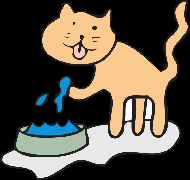

In [6]:
display.Image('../images/manka.png')

In [7]:
print(resnet50.infer_single_image('../images/manka.png',5))

{  n03595614	運動衫: (610, 0.18088461),  n03598930	拼圖: (611, 0.16258661),  n02834397	（小兒用的）圍嘴: (443, 0.05911544),  n03063599	咖啡杯: (504, 0.04249492),  n06596364	漫畫: (917, 0.04106267) }


那要如何獲取數據集?數據清洗會不會很複雜呢??放心，為了這次課程所開發的API trident其中最重要的任務就是要讓各位不用管太多開發細節，因此數據集我們包裝成一行指令就能存取(dataset=T.load_examples_data('animals'))，至於圖像的整理清洗，直接在數據集的image_transform_funcs清單中依序加入清洗數據所需要的處理函數，至於不同框架間的通道在前在後，以及標籤該是onehot還是整數，放心都會自動化處理掉。這個實作是pytorch版，所以會依照通道在前，標籤保持整數型別的方式處理。

In [8]:
data_provider=T.load_examples_data('animals')
data_provider.image_transform_funcs=[
                     RandomCenterCrop((224,224),scale_range=(0.8,2)),
                     #原比例隨機縮放(正確縮放比例再乘上0.8~1.2之間隨機數)中央裁切至224,224
                     RandomAdjustGamma(gamma_range=(0.6,1.5)),
                     #隨機調整圖片明暗gamma 0.6~1.4之間
                     RandomAdjustContrast(value_range=(0.6, 1.5)),
                     #隨機調整圖片對比度
                     RandomTransform(rotation_range=20,zoom_range=0.1,shift_range=0.02,shear_range=0.02,random_flip=0.2),
                     Normalize(0,255),#除以255
                     Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])] #透過imagenet像素均值標準差再做一次正規化
data_provider.minibatch_size=16

archive file is already existing, donnot need download again.
Starting to decompress the archive....
C:/Users/Allan/.trident/datasets/examples_animals
['cat', 'chipmunk', 'dog', 'fox', 'giraffe', 'guinea pig', 'hyena', 'reindeer', 'sikadeer', 'squirrel', 'weasel', 'wolf']
C:/Users/Allan/.trident/datasets/examples_animals/cat/*.*g
2766
C:/Users/Allan/.trident/datasets/examples_animals/chipmunk/*.*g
2829
C:/Users/Allan/.trident/datasets/examples_animals/dog/*.*g
3132
C:/Users/Allan/.trident/datasets/examples_animals/fox/*.*g
3191
C:/Users/Allan/.trident/datasets/examples_animals/giraffe/*.*g
3233
C:/Users/Allan/.trident/datasets/examples_animals/guinea pig/*.*g
2970
C:/Users/Allan/.trident/datasets/examples_animals/hyena/*.*g
2679
C:/Users/Allan/.trident/datasets/examples_animals/reindeer/*.*g
3158
C:/Users/Allan/.trident/datasets/examples_animals/sikadeer/*.*g
2857
C:/Users/Allan/.trident/datasets/examples_animals/squirrel/*.*g
2551
C:/Users/Allan/.trident/datasets/examples_animals/weas

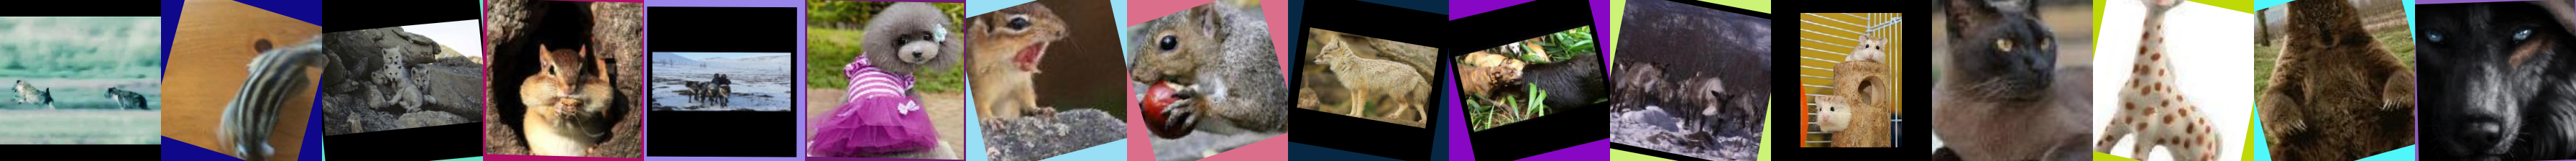

In [9]:

data,label=data_provider.next()
data_provider.preview_images()


In [10]:
finetune_resnet50=resnet.ResNet50(include_top=True,pretrained=True,input_shape=(224,224,3),classes=12)


model file is already existing, donnot need download again.


我們可以利用summary()來檢視一下網路結構，以及個別需要的算力，其中總計參數與總計可訓練參數都是23,532,620。但是別忘了，如果它們都可以訓練，代表當它一接觸到新的數據，就可能讓權重發生變化，效果可能就會大打折扣，那麼如何兼顧遷移學習以及保持預訓練的基本優勢，那麼我們可以將部分的權重的trainable設置為False

In [11]:
finetune_resnet50.summary()

--------------------------------------------------------------------------------------------------------------------------------
                   Layer (type)                          Output Shape               Weight           Bias    Param #            FLOPS #         
conv1.conv  Conv2d                                [1, 112, 112, 64]        [7, 7, 3, 64]               9,408   236,015,360.0            
conv1.norm  BatchNorm                             [1, 112, 112, 64]        [64]                [64]    128     2,395,904.0              
conv1  Conv2d_Block                               [1, 112, 112, 64]                                    0       0.0                      
maxpool  MaxPool2d                                [1, 56, 56, 64]                                      0       0.0                      
layer1.0.0.conv  Conv2d                           [1, 56, 56, 256]         [1, 1, 64, 256]             16,384  102,757,312.0            
layer1.0.0.norm  BatchNorm               

ImageClassificationModel(
  (inputs): TensorSpec(shape=(None, 224, 224, 3), ndim=4, name=input)
  (_outputs): { output_0: TensorSpec(object_type=ObjectType.classification_label, name=output_0), output_1: TensorSpec(shape=(None, 12), name=output_1) }
  (_targets): TensorSpec(object_type=ObjectType.classification_label, name=output_0)
  (_targets): TensorSpec(shape=(None, 12), name=output_1)
)

下面的指令是將整個模型的所有模型都設為不可學習，各位可以看到，可訓練參數數立刻就變0了
Total params: 23,532,620
Trainable params: 0
Non-trainable params: 23,532,620

In [12]:
finetune_resnet50.model.trainable=False
finetune_resnet50.summary()

23532620 parameters have set untrainable
--------------------------------------------------------------------------------------------------------------------------------
                   Layer (type)                          Output Shape               Weight           Bias    Param #            FLOPS #         
conv1.conv  Conv2d                                [1, 112, 112, 64]        [7, 7, 3, 64]               9,408   236,015,360.0            
conv1.norm  BatchNorm                             [1, 112, 112, 64]        [64]                [64]    128     2,395,904.0              
conv1  Conv2d_Block                               [1, 112, 112, 64]                                    0       0.0                      
maxpool  MaxPool2d                                [1, 56, 56, 64]                                      0       0.0                      
layer1.0.0.conv  Conv2d                           [1, 56, 56, 256]         [1, 1, 64, 256]             16,384  102,757,312.0            


ImageClassificationModel(
  (inputs): TensorSpec(shape=(None, 224, 224, 3), ndim=4, name=input)
  (_outputs): { output_0: TensorSpec(object_type=ObjectType.classification_label, name=output_0), output_1: TensorSpec(shape=(None, 12), name=output_1) }
  (_targets): TensorSpec(object_type=ObjectType.classification_label, name=output_0)
  (_targets): TensorSpec(shape=(None, 12), name=output_1)
)

由於resnet的結構是(1)first_layer (2)maxpool (3)layer1 (4)layer2 (5)layer3 (6)layer4 (7) globalavg (8) fc
其中fc只是一個分類器，而我們也已經把他從imagenet的1000置換成12，所以它是可以開啟學習的。

In [13]:
finetune_resnet50.model.fc.trainable=True

finetune_resnet50.summary()

24588 parameters have set trainable
--------------------------------------------------------------------------------------------------------------------------------
                   Layer (type)                          Output Shape               Weight           Bias    Param #            FLOPS #         
conv1.conv  Conv2d                                [1, 112, 112, 64]        [7, 7, 3, 64]               9,408   236,015,360.0            
conv1.norm  BatchNorm                             [1, 112, 112, 64]        [64]                [64]    128     2,395,904.0              
conv1  Conv2d_Block                               [1, 112, 112, 64]                                    0       0.0                      
maxpool  MaxPool2d                                [1, 56, 56, 64]                                      0       0.0                      
layer1.0.0.conv  Conv2d                           [1, 56, 56, 256]         [1, 1, 64, 256]             16,384  102,757,312.0            
layer

ImageClassificationModel(
  (inputs): TensorSpec(shape=(None, 224, 224, 3), ndim=4, name=input)
  (_outputs): { output_0: TensorSpec(object_type=ObjectType.classification_label, name=output_0), output_1: TensorSpec(shape=(None, 12), name=output_1) }
  (_targets): TensorSpec(object_type=ObjectType.classification_label, name=output_0)
  (_targets): TensorSpec(shape=(None, 12), name=output_1)
)

以訓練初期來說，建議大部分的權重保留，可以只訓練分類器，但是由於這個題目本身難度較高，光用原有的特徵圖恐怕不敷使用，所以建議是先訓練分類器，然後跑一段時間後才開放layer4進行學習(通常是開放最末端trainable)。那要如何做到這樣可以訓練到一半才將指定層權重設為trainable?可以利用trident裡的Callback功能，可以繼承CallbackBase，利用其中的on_batch_end事件，由於訓練過程中的信息都會記錄在training_context中，可以透過對training_context存取來獲得現在的信息，在以下語法中是根據training_context['current_batch']來判斷目前是第幾個批次，當第一個批次執行完，我會讓它把目前第一個批次的各個損失函數的內容列印出來，當跑完第200個批次後，將layer4設為trainable=True

In [14]:
#自訂callbacks
class CustomCallback(CallbackBase):
    def __init__(self):
        super(CustomCallback, self).__init__()
    def on_batch_end(self, training_context):
        if training_context['steps']==200:
            training_context['current_model'].layer4.trainable=True #透過training_context切換模型指定層的trainable狀態
            
        elif training_context['steps']==1000:
            training_context['current_model'].layer3[5].trainable=True #透過training_context切換模型指定層的trainable狀態
            
        elif training_context['steps']==2000:
            training_context['current_model'].layer3[4].trainable=True #透過training_context切換模型指定層的trainable狀態
            
        if training_context['steps']>0 and training_context['steps']%1500==0:
            training_context['optimizer'].lr=training_context['optimizer'].lr*0.5
            #每訓練1500批次，學習速率降一半
    

接下來是跟之前實作都差不多的步驟，指定優化器(別再用Adam了，在此強烈推薦ranger)，指定損失函數、評價函數(top1以及top3正確率)，加入l2正則以及權重約束min_max_norm，以及設定存檔路徑。

In [15]:
finetune_resnet50=finetune_resnet50\
    .with_optimizer(optimizer='Ranger',lr=1e-3,betas=(0.9, 0.999))\
    .with_loss(CrossEntropyLoss)\
    .with_metric(accuracy,name='accuracy')\
    .with_metric(accuracy,topk=3,name='top3_accuracy')\
    .with_regularizer('l2')\
    .with_constraint('min_max_norm')\
    .with_model_save_path('Models/finetune_resnet50.pth')\
    

#finetune_resnet50.load_model('Models/finetune_resnet50.pth')

CrossEntropyLoss( output, target) -> CrossEntropyLoss 
accuracy( output, target) -> accuracy 
top3_accuracy( output, target) -> top3_accuracy 


![Alt text](../images/animals_overview.jpg)

![Alt text](../images/cutmix.png)

In [16]:
finetune_resnet50=finetune_resnet50\
    .with_callbacks(CutMixCallback(alpha=1,loss_criterion=CrossEntropyLoss,loss_weight=0.2))\
    .with_callbacks(MixupCallback(alpha=1,loss_criterion=CrossEntropyLoss,loss_weight=0.2))\
    .with_callbacks(CustomCallback())

plan=TrainingPlan()\
    .add_training_item(finetune_resnet50)\
    .with_data_loader(data_provider)\
    .repeat_epochs(5)\
    .with_batch_size(16)\
    .print_progress_scheduling(20,unit='batch')\
    .save_model_scheduling(100,unit='batch')\
    .display_loss_metric_curve_scheduling(200,unit='batch',imshow=True)


data_feed for resnet50 :{ input: image, output: output, target: target, output_0: output_0, output_1: output_1 }
data_feed { input: image, output: output, target: label, output_0: output_0, output_1: output_1 }
resnet50     Step: 1s288ms  | Loss: 10.264 | accuracy: 0.000e+00 ,top3_accuracy: 18.750%  | learning rate: 1.000e-03  | epoch: 0  ( 0/2214 )
resnet50     Step: 14s366ms | Loss: 7.147 | accuracy: 9.524% ,top3_accuracy: 23.214%  | learning rate: 1.000e-03  | epoch: 0  ( 20/2214 )
resnet50     Step: 12s579ms | Loss: 6.038 | accuracy: 7.812% ,top3_accuracy: 27.500%  | learning rate: 1.000e-03  | epoch: 0  ( 40/2214 )
resnet50     Step: 12s116ms | Loss: 5.462 | accuracy: 9.688% ,top3_accuracy: 24.375%  | learning rate: 1.000e-03  | epoch: 0  ( 60/2214 )
resnet50     Step: 11s982ms | Loss: 5.104 | accuracy: 10.312% ,top3_accuracy: 31.250%  | learning rate: 1.000e-03  | epoch: 0  ( 80/2214 )
resnet50     Step: 19s39ms  | Loss: 4.860 | accuracy: 9.375% ,top3_accuracy: 27.187%  | learnin

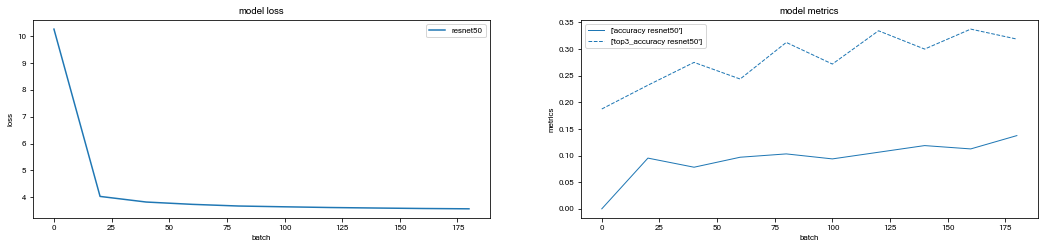

14964736 parameters have set trainable
resnet50     Step: 13s671ms | Loss: 4.281 | accuracy: 14.688% ,top3_accuracy: 37.188%  | learning rate: 1.000e-03  | epoch: 0  ( 200/2214 )
resnet50     Step: 19s247ms | Loss: 4.223 | accuracy: 10.000% ,top3_accuracy: 25.938%  | learning rate: 1.000e-03  | epoch: 0  ( 220/2214 )
resnet50     Step: 19s240ms | Loss: 4.175 | accuracy: 11.250% ,top3_accuracy: 26.562%  | learning rate: 1.000e-03  | epoch: 0  ( 240/2214 )
resnet50     Step: 20s82ms  | Loss: 4.135 | accuracy: 9.688% ,top3_accuracy: 27.500%  | learning rate: 1.000e-03  | epoch: 0  ( 260/2214 )
resnet50     Step: 19s172ms | Loss: 4.100 | accuracy: 11.562% ,top3_accuracy: 27.187%  | learning rate: 1.000e-03  | epoch: 0  ( 280/2214 )
resnet50     Step: 19s217ms | Loss: 4.071 | accuracy: 8.750% ,top3_accuracy: 25.000%  | learning rate: 1.000e-03  | epoch: 0  ( 300/2214 )
resnet50     Step: 19s563ms | Loss: 4.045 | accuracy: 12.188% ,top3_accuracy: 28.750%  | learning rate: 1.000e-03  | epoch:

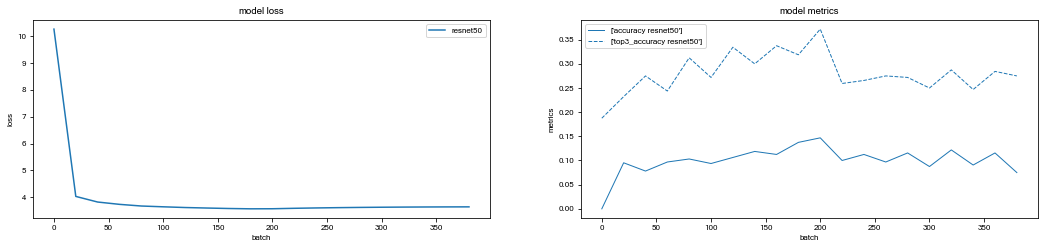

resnet50     Step: 19s63ms  | Loss: 3.653 | accuracy: 10.445% ,top3_accuracy: 28.294%  | learning rate: 1.000e-03  | epoch: 0  ( 400/2214 )
resnet50     Step: 22s88ms  | Loss: 3.634 | accuracy: 10.411% ,top3_accuracy: 28.346%  | learning rate: 1.000e-03  | epoch: 0  ( 420/2214 )
resnet50     Step: 28s618ms | Loss: 3.625 | accuracy: 10.447% ,top3_accuracy: 28.139%  | learning rate: 1.000e-03  | epoch: 0  ( 440/2214 )
resnet50     Step: 19s886ms | Loss: 3.620 | accuracy: 10.381% ,top3_accuracy: 28.092%  | learning rate: 1.000e-03  | epoch: 0  ( 460/2214 )
resnet50     Step: 28s130ms | Loss: 3.619 | accuracy: 10.285% ,top3_accuracy: 27.741%  | learning rate: 1.000e-03  | epoch: 0  ( 480/2214 )
resnet50     Step: 19s589ms | Loss: 3.619 | accuracy: 10.244% ,top3_accuracy: 27.598%  | learning rate: 1.000e-03  | epoch: 0  ( 500/2214 )
resnet50     Step: 24s614ms | Loss: 3.620 | accuracy: 10.149% ,top3_accuracy: 27.133%  | learning rate: 1.000e-03  | epoch: 0  ( 520/2214 )


In [ ]:
plan.start_now()


In [ ]:
#finetune_resnet50.class_names=data_provider.class_names['en-us']

finetune_resnet50.class_names=['貓 cat', '花栗鼠 chipmunk ', '狗 dog', '狐狸 fox', '長頸鹿 giraffe', '天竺鼠 guinea pig', '鬣狗 hyena', '馴鹿 reindeer', '梅花鹿 sikadeer', '松鼠 squirrel', '黃鼠狼 weasel', '狼 wolf']
print(finetune_resnet50.class_names)
finetune_resnet50.eval()

模型訓練好後，我們利用infer_single_image來看一下預測效果，首先是那隻手繪的貓，這次模型答對了，機率高達99.7%

In [ ]:
print(finetune_resnet50.infer_single_image('../images/manka.png',5))
display.Image('../images/manka.png')

那扮成美國隊長的貓呢?抱歉，模型還是答錯了，以為它是一隻鬣狗，不過各位可以發現模型對於沒把握，可能答錯這件事還是容易判斷的，你看他回答的最高機率只有23.6%%

In [ ]:
print(finetune_resnet50.infer_single_image('../images/captaincat.jpg',topk=3))
display.Image('../images/captaincat.jpg')

接下來是我當時故意設計的超難題，非洲十萬年前石壁壁畫，而這次模型也答對了。

In [ ]:
print(finetune_resnet50.infer_single_image('../images/africa.jpg',topk=3))
display.Image('../images/africa.jpg')



剪紙屬於高度的抽象畫與變形，即使是如此高度抽象的圖像，模型依然是正確的。

In [ ]:
print(finetune_resnet50.infer_single_image('../images/paper.jpg',topk=3))
display.Image('../images/paper.jpg')

大家熟悉的海賊王喬巴，模型認為他是鬣狗的機率大於馴鹿。

In [ ]:
print(finetune_resnet50.infer_single_image('../images/joba.jpg',topk=3))
display.Image('../images/joba.jpg')

機器會認為它是狗還是長頸鹿呢?答案是機器能判斷它是一隻扮成長頸鹿的狗。

In [ ]:
print(finetune_resnet50.infer_single_image('../images/fakegiraffe.jpg',topk=3))
display.Image('../images/fakegiraffe.jpg')

這個像拖把的物體其實是稀有的長毛天竺鼠，機器也答對了。

In [ ]:
print(finetune_resnet50.infer_single_image('../images/longhair.jpg',topk=3))
display.Image('../images/longhair.jpg')#這是稀有品種長毛天竺鼠



但如果是最近爆紅的天竺鼠PUI PUI，很抱歉，機器的訓練集沒有類似的圖片，所以機器答錯了，他以為這些是一堆狗。

In [ ]:
print(finetune_resnet50.infer_single_image('../images/pupu.jpg',topk=3))
display.Image('../images/pupu.jpg')